# Sample analysis scripts for SUMMA

## June 2014

imports and definitions

In [ ]:
import argparse
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np
import netCDF4
import os
import pandas as pd

In [8]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=16)
mpl.rc('legend', fontsize=16)

In [9]:
Tfreeze    = 273.16
iden_ice   = 917.
iden_water = 1000.
secphour   = 3600.
verbose = False

In [17]:
# Snow depth measurements for Reynolds Creek
valFile = os.path.expanduser('~/SUMMA_SWGR/validation_data/reynolds/ReynoldsCreek_valData.nc')
valVarname = 'zs_sheltered'

outpath = os.path.expanduser('~/SUMMA_SWGR/output/reynolds/sheltered_2005-2006')
inpath = os.path.expanduser('~/SUMMA_SWGR/output/reynolds')

### Functions and such

### Based on Martyn's clark script to read and plot a time series for a variable

Plot observed and modeled time series

In [11]:
def plot1D(simFile, simVarname, ihru=0, valFile=None, valVarname=None,
           simMult=None, valMult=None, simOffset=None, valOffset=None,
           colors=['red', 'black'], title=None, ylabel=None,
           pltFile=None, pltFormat='pdf'):

    '''
    Plot a 1D time series from SUMMA output files.

    Required:

    simFile:
        Full path for SUMMA output file

    simVarname:
    '''

    fig = plt.figure(figsize=(15, 7.5))

    # Read and plot the simulation data
    nc = netCDF4.Dataset(simFile, 'r')
    simDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
    if simVarname == 'snowpackOutflow':
        simVar = nc.variables['scalarRainPlusMelt'][:,ihru]
        simVar[nc.variables['nSnow'][:,ihru]==0] = 0
    else:
        simVar = nc.variables[simVarname][:,ihru]

    if simMult:
        simVar *= simMult
    if simOffset:
        simVar += simOffset
    sts = pd.Series(simVar, index=simDates)
    if not ylabel:
        if simVarname == 'snowpackOutflow':
            units = nc.variables['scalarRainPlusMelt'].units
        else:
            units = nc.variables[simVarname].units
        ylabel = '{} ({})'.format(simVarname, units)

    if valFile:
        # read the validation data
        nc = netCDF4.Dataset(valFile, 'r')
        valDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
        valVar = nc.variables[valVarname][:]
        if valMult:
            valVar *= valMult
        if valOffset:
            valVar += valOffset
        nc.close()
        vts = pd.Series(valVar, index=valDates)

    if valFile:
        start = max(sts.index[0], vts.index[0])
        end = min(sts.index[-1], vts.index[-1])
    else:
        start = sts.index[0]
        end = sts.index[-1]

    sts = sts[start:end]
    sts.plot(color=colors[0], label='Simulated')
    if valFile:
        vts = vts[start:end]
        vts.plot(color=colors[1], label='Observations')
    plt.xlim(start, end)
    plt.legend()
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if pltFile:
        plt.savefig(pltFile, format=pltFormat)

In [12]:
def plot_diurnal(simFile, simVarname, ihru=0, valFile=None, valVarname=None,
                 simMult=None, valMult=None, simOffset=None, valOffset=None,
                 month=None, colors=['red', 'black'], title=None, ylabel=None,
                 pltFile=None, pltFormat='pdf'):

    fig = plt.figure(figsize=(15, 7.5))

    # Read and plot the simulation data
    nc = netCDF4.Dataset(simFile, 'r')
    simDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
    if simVarname == 'snowpackOutflow':
        simVar = nc.variables['scalarRainPlusMelt'][:,ihru]
        simVar[nc.variables['nSnow'][:,ihru]==0] = 0
    else:
        simVar = nc.variables[simVarname][:,ihru]
    if simMult:
        simVar *= simMult
    if simOffset:
        simVar += simOffset
    sts = pd.Series(simVar, index=simDates)
    if not ylabel:
        if simVarname == 'snowpackOutflow':
            units = nc.variables['scalarRainPlusMelt'].units
        else:
            units = nc.variables[simVarname].units
        ylabel = '{} ({})'.format(simVarname, units)
    nc.close()

    if valFile:
        # read the validation data
        nc = netCDF4.Dataset(valFile, 'r')
        valDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
        valVar = nc.variables[valVarname][:]
        if valMult:
            valVar *= valMult
        if valOffset:
            valVar += valOffset
        vts = pd.Series(valVar, index=valDates)
        nc.close()

    if valFile:
        start = max(sts.index[0], vts.index[0])
        end = min(sts.index[-1], vts.index[-1])
    else:
        start = sts.index[0]
        end = sts.index[-1]

    sts = sts[start:end]
    if month:
        sts = sts[sts.index.month==month]
        if not title:
            title = ''
        title = 'Month {}: diurnal mean {}'.format(month, title)
    sts = sts.groupby(sts.index.hour).mean()
    sts.plot(color=colors[0], label='Simulated')
    if valFile:
        vts = vts[start:end]
        if month:
            vts = vts[vts.index.month==month]
        vts = vts.groupby(vts.index.hour).mean()
        vts.plot(color=colors[1], label='Observations')
    plt.xlim(0, 24)
    plt.legend()
    plt.xlabel('Hour of the day')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if pltFile:
        plt.savefig(pltFile, format=pltFormat)

In [13]:
def ncread2D(ncFile, ihru=0):
    nc_layer_vars = ['nSnow', 'nSoil', 'nLayers',
                     'midSoilStartIndex', 'midTotoStartIndex',
                     'ifcTotoStartIndex', 'ifcSnowStartIndex']


    s_state_dims = {
        'iLayerHeight'          :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerDepth'           :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerHeight'          :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerTemp'            :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerVolFracIce'      :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerVolFracLiq'      :  {'istart_ix': 'ifcTotoStartIndex',
                                    'mstart_ix': 'midTotoStartIndex',
                                    'nElements': 'nLayers'},
        'mLayerMatricHead'      :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
        'mLayerTranspireLim'    :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
        'mLayerTranspire'       :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
        'mLayerQMacropore'      :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
        'mLayerColumnInflow'    :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
        'mLayerColumnOutflow'   :  {'istart_ix': 'ifcTotoStartIndex',
                                    'istart_offset': 'nSnow',
                                    'mstart_ix': 'midSoilStartIndex',
                                    'nElements': 'nSoil'},
    }

    nc_state_vars = s_state_dims.keys()

    nc = netCDF4.Dataset(ncFile, 'r')
    simDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)

    s_layer_data = {}
    for var in nc_layer_vars:
        s_layer_data[var] = nc.variables[var][:,ihru]
    s_layer_df = pd.DataFrame(s_layer_data, index=simDates)

    s_state_data = {}
    for var in nc_state_vars:
        s_state_data[var] = nc.variables[var][:,ihru]
    s_state_df = pd.DataFrame(s_state_data)

    nc.close()

    return (s_layer_df, s_state_df, s_state_dims)

In [14]:
def plot2D(simFile, simVarname, cmaplabel, layerVar='iLayerHeight',
           valFile=None, valVarname=None, crange=None,
           simMult=None, valMult=None, simOffset=None, valOffset=None,
           cmap=mpl.cm.jet, color='black',
           title=None, pltFile=None, pltFormat='pdf'):
    s_layer_df, s_state_df, s_state_dims = ncread2D(simFile)
    z = np.empty(0)
    verts = np.empty((4,0,2))
    dx0 = (s_layer_df.index[0]-s_layer_df.index[0]).total_seconds()/86400.
    dx1 = (s_layer_df.index[1]-s_layer_df.index[0]).total_seconds()/86400.
    for now in s_layer_df.index:
        nElements = s_layer_df[s_state_dims[simVarname]['nElements']][now]
        mstart_ix = s_layer_df[s_state_dims[simVarname]['mstart_ix']][now]-1
        nLayers = nElements + 1

        istart_ix = s_layer_df[s_state_dims[layerVar]['istart_ix']][now]-1
        if 'istart_offset' in s_state_dims[simVarname]:
            istart_ix += s_layer_df[s_state_dims[simVarname]['istart_offset']][now]
        vals = s_state_df[simVarname][mstart_ix:mstart_ix+nElements]
        if simMult:
            vals *= simMult
        if simOffset:
            vals += simOffset
        lvals = s_state_df[layerVar][istart_ix:istart_ix+nLayers]

        x = np.repeat(mpl.dates.date2num(now), nElements)
        y = -lvals[1:]
        h = lvals[1:].values - lvals[:-1].values
        ll = np.dstack([x,y])[0]
        offsets = np.zeros((4, nElements, 2), dtype=object)
        offsets[0] = np.repeat([[dx0, 0]], nElements, axis = 0)
        offsets[1] = np.repeat([[dx1, 0]], nElements, axis = 0)
        offsets[2] = np.dstack([np.repeat(dx1, nElements), h])
        offsets[3] = np.dstack([np.repeat(dx0, nElements), h])
        z = np.append(z, vals)
        verts = np.append(verts, ll+offsets, axis=1)

    verts = np.swapaxes(verts, 0, 1)

    if not crange:
        crange = [z.min(), z.max()]
    norm = mpl.colors.Normalize(crange[0], crange[1])

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    coll = PolyCollection(verts, array=z, cmap=cmap, norm=norm, edgecolors='none')
    ax.add_collection(coll)

    if valFile:
        # read the validation data
        nc = netCDF4.Dataset(valFile, 'r')
        valDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
        valDates = mpl.dates.date2num(valDates)
        idx = np.where((valDates >= verts[0,0,0]) & (valDates <= verts[-1,1,0]))
        valDates = valDates[idx]
        valVar = nc.variables[valVarname][:]
        valVar = valVar[idx]
        if valMult:
            valVar *= valMult
        if valOffset:
            valVar += valOffset
        nc.close()
        plt.plot(valDates, valVar, color=color, label='Observations', lw=3)

    ax.autoscale_view()
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.ylabel("Height above the soil surface (m)")
    plt.xlim(verts[0,0,0],verts[-1,1,0])
    if valFile:
        plt.legend()
    plt.colorbar(coll, label=cmaplabel)

    if title:
        plt.title(title)
    if pltFile:
        plt.savefig(pltFile, format=pltFormat)


In [15]:
def plot2D_fast(simFile, simVarname, cmaplabel, layerVar='iLayerHeight',
                valFile=None, valVarname=None, crange=None,
                simMult=None, valMult=None, simOffset=None, valOffset=None,
                cmap=mpl.cm.jet, color='black',
                title=None, pltFile=None, pltFormat='pdf'):
    s_layer_df, s_state_df, s_state_dims = ncread2D(simFile)
    z = np.empty(0)
    verts = np.empty((2,0,2))
    dx0 = (s_layer_df.index[0]-s_layer_df.index[0]).total_seconds()/86400.
    for now in s_layer_df.index:
        nElements = s_layer_df[s_state_dims[simVarname]['nElements']][now]
        mstart_ix = s_layer_df[s_state_dims[simVarname]['mstart_ix']][now]-1
        nLayers = nElements + 1

        istart_ix = s_layer_df[s_state_dims[layerVar]['istart_ix']][now]-1
        if 'istart_offset' in s_state_dims[simVarname]:
            istart_ix += s_layer_df[s_state_dims[simVarname]['istart_offset']][now]
        vals = s_state_df[simVarname][mstart_ix:mstart_ix+nElements]
        if simMult:
            vals *= simMult
        if simOffset:
            vals += simOffset
        lvals = s_state_df[layerVar][istart_ix:istart_ix+nLayers]

        x = np.repeat(mpl.dates.date2num(now), nElements)
        y = -lvals[1:]
        h = lvals[1:].values - lvals[:-1].values
        ll = np.dstack([x,y])[0]
        offsets = np.zeros((2, nElements, 2), dtype=object)
        offsets[0] = np.repeat([[dx0, 0]], nElements, axis = 0)
        offsets[1] = np.dstack([np.repeat(dx0, nElements), h])
        z = np.append(z, vals)
        verts = np.append(verts, ll+offsets, axis=1)

    verts = np.swapaxes(verts, 0, 1)

    if not crange:
        crange = [z.min(), z.max()]
    norm = mpl.colors.Normalize(crange[0], crange[1])

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    coll = LineCollection(verts, array=z, cmap=cmap, norm=norm, lw=1)
    ax.add_collection(coll)

    if valFile:
        # read the validation data
        nc = netCDF4.Dataset(valFile, 'r')
        valDates = netCDF4.num2date(nc.variables['time'][:], units=nc.variables['time'].units)
        valDates = mpl.dates.date2num(valDates)
        idx = np.where((valDates >= verts[0,0,0]) & (valDates <= verts[-1,0,0]))
        valDates = valDates[idx]
        valVar = nc.variables[valVarname][:]
        valVar = valVar[idx]
        if valMult:
            valVar *= valMult
        if valOffset:
            valVar += valOffset
        nc.close()
        plt.plot(valDates, valVar, color=color, label='Observations', lw=3)

    ax.autoscale_view()
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.ylabel("Height above the soil surface (m)")
    plt.xlim(verts[0,0,0],verts[-1,0,0])
    if valFile:
        plt.legend()
    plt.colorbar(coll, label=cmaplabel)

    if title:
        plt.title(title)
    if pltFile:
        plt.savefig(pltFile, format=pltFormat)


### And now for some actual plots

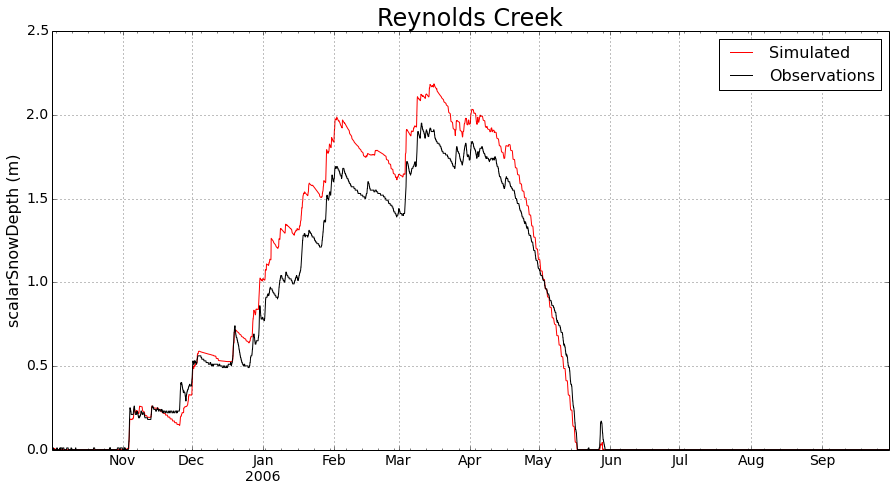

In [9]:
experiment = 'sheltered_2005-2006_ex1a'
simFile = os.path.join(inpath, '{}.nc'.format(experiment))
simVarname = 'scalarSnowDepth'
pltFile = os.path.join(outpath, experiment+'.{}.ts.pdf'.format(simVarname))
plot1D(simFile, simVarname, valFile=valFile, valVarname=valVarname, valMult=0.01,
       title='Reynolds Creek', pltFile=pltFile)

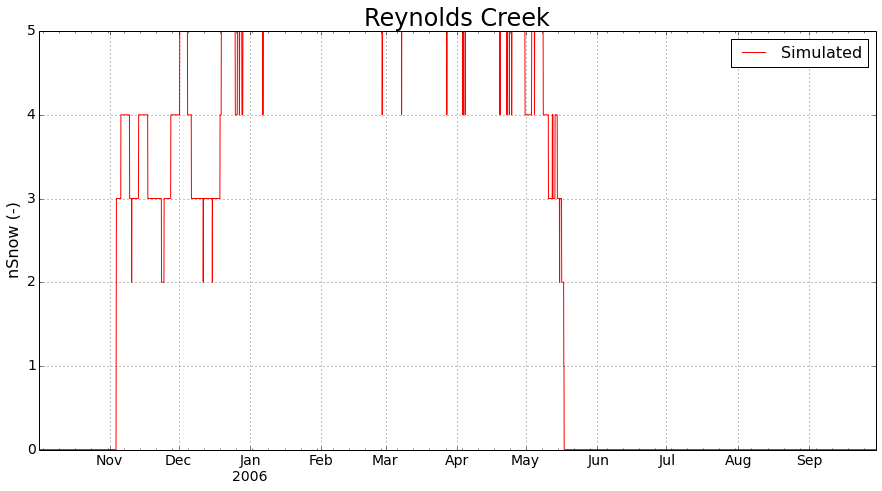

In [10]:
simVarname = 'nSnow'
plot1D(simFile, simVarname, title='Reynolds Creek')

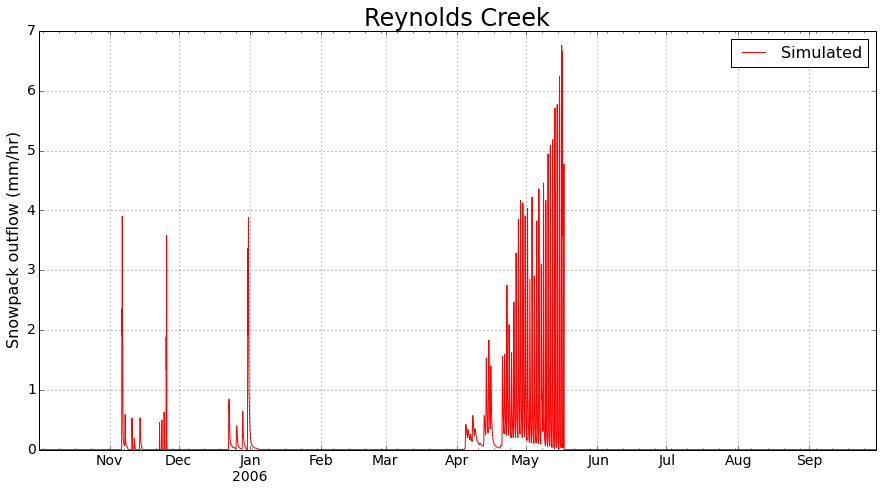

In [13]:
simVarname = 'snowpackOutflow'
plot1D(simFile, simVarname, simMult=1000.*3600., ylabel='Snowpack outflow (mm/hr)', title='Reynolds Creek')

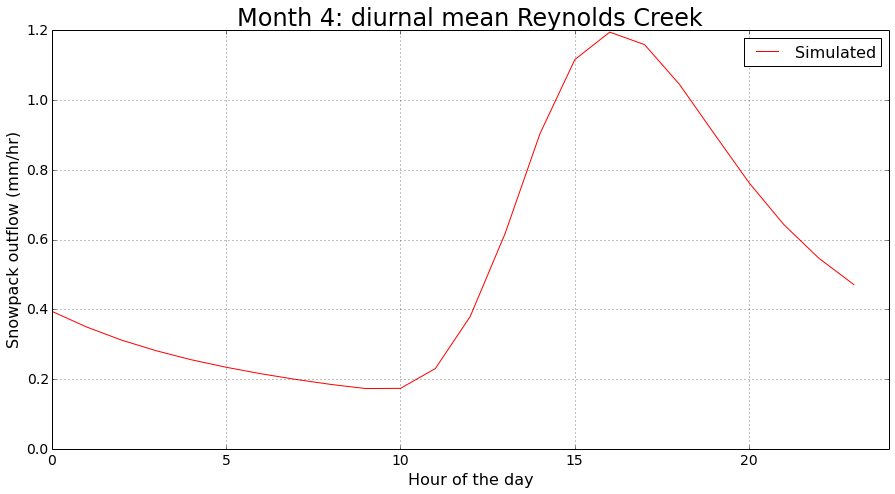

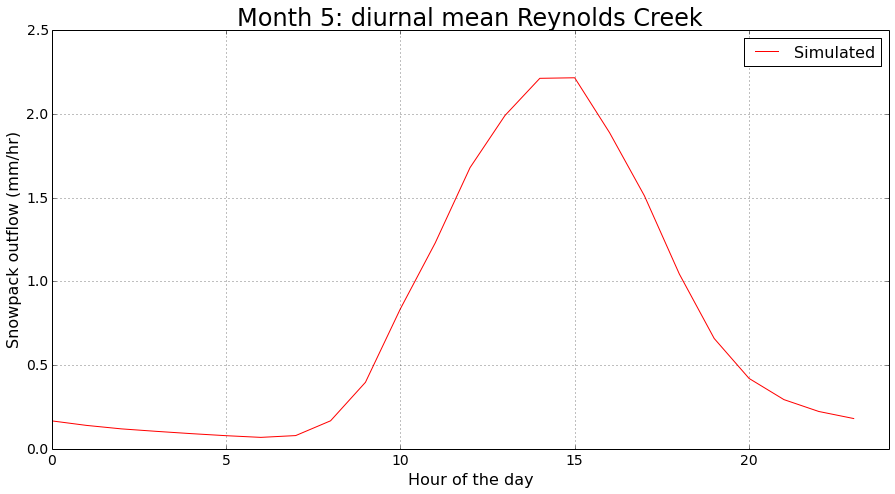

In [18]:
simVarname = 'snowpackOutflow'
plot_diurnal(simFile, simVarname, simMult=1000.*3600., ylabel='Snowpack outflow (mm/hr)', title='Reynolds Creek', month=4)
plot_diurnal(simFile, simVarname, simMult=1000.*3600., ylabel='Snowpack outflow (mm/hr)', title='Reynolds Creek', month=5)

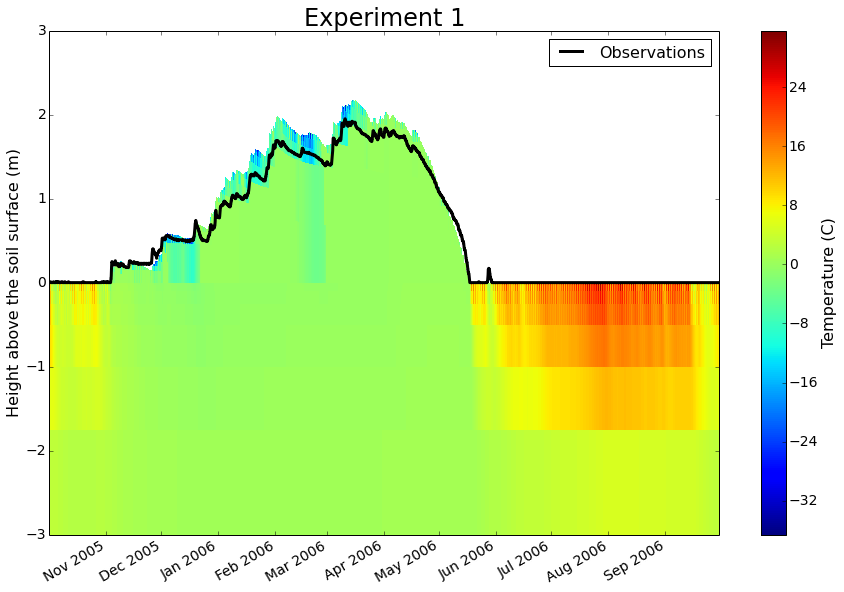

In [15]:
plot2D(simFile, 'mLayerTemp', cmaplabel='Temperature (C)', 
       valFile=valFile, valVarname=valVarname, crange=None, 
       simMult=1, valMult=0.01, cmap=mpl.cm.jet, color='black',
       title=experiment)